In [1]:
import os
import sys
from scipy import stats
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

from string import ascii_lowercase as abc
abc = [*abc] + [f'{l}2' for l in abc]

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }

palette_educated = sb.color_palette('Oranges', 16)[:8]
palette_naive_test = 'Blues'
palette_naive_ot1 = 'Greens'
palette_human = sb.color_palette('Reds', 16)[8-1:]

color_greedy = 'silver'
color_active = 'tab:orange'
color_random = 'grey'
color_human = palette_tcrs['Human']

In [6]:
palette_pos = sb.color_palette('Set2', 9)#[2:]
palette_pos = dict(zip(range(1, 10), palette_pos))

In [7]:
palette_active = {'Active': palette_tcrs['Educated'],
                  'Random': color_random,
                 }

## Load data

In [8]:
def load_experiment(filename):
    path_exp = f'../activation-prediction/results/active_learning/{filename}'
    with open(path_exp) as f:
        results_exp = json.load(f)
    return results_exp

In [9]:
results_within_mice = {
    'Active': load_experiment('within/SIINFEKL_FULL_act_avg_8.json'),
    'Random': load_experiment('within/SIINFEKL_FULL_rdm_8.json'),
}

In [10]:
def get_mutation(apl, base):
    for i, (l1, l2) in enumerate(zip(apl, base)):
        if l1 != l2:
            return i+1, l1
    return '-', 'None'
    
def load_used_apls(filename):
    path_apls = f'../activation-prediction/results/active_learning/{filename}'
    base_epitope = 'SIINFEKL' if 'SIINFEKL' in filename else 'VPSVWRSSL'
    
    df_apls = pd.read_csv(path_apls, skiprows = 1,header = None)
    columns = ['seed', 'tcr'] + list(range(1, len(df_apls.columns)-1))
    df_apls.columns = columns
    df_apls[1] = df_apls[1].str[1:]
    df_apls[columns[-1]] = df_apls[columns[-1]].str[:-1]
    
    if 'within' in filename:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 81))]
    else:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 80))]
    
    for col in df_apls.columns:
        if col in ['seed', 'tcr']:
            continue
        df_apls[col] = df_apls[col].str.strip().str[1:-1]
        df_apls[f'pos_{col}'], df_apls[f'aa_{col}'] = zip(*df_apls[col].apply(lambda x: get_mutation(x, base_epitope)))        
    return df_apls

In [11]:
apls_within_mice = {
    'Active': load_used_apls('within/SIINFEKL_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/SIINFEKL_selectedAPLs_add_by_random.csv'),
}

## Plotting function

In [12]:
def plot_performance(data, metric, methods, ax=None, xticks=None, legend=False, active_color=None):
    dfs_results = []
    for method in methods:
        df = pd.DataFrame(data[method][metric])
        columns = ['tcr', 'educated', 'iteration', metric] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    
    #threshold = df_joint[(df_joint['method']=='Random') & (df_joint['iteration']==9)][metric].mean()
    threshold = 0.7 if metric == 'Spearman' else 0.85
    ax.axhline(threshold, linestyle='dashed', color='lightgray', linewidth=1)
    
    #x_thresh = df_joint[(df_joint['method']=='Active')].groupby('iteration')[metric].mean()
    #x_thresh = x_thresh[x_thresh>threshold].index[0]
    
    x_thresh = 2
    ax.axvline(x_thresh, linestyle='dashed', color='lightgray', linewidth=1)
    
    colors = {
        'Greedy_auc': color_greedy,
        'Greedy_spearman': color_greedy,
        'Active': color_active if active_color is None else active_color,
        'Random': color_random,
    }
    
    plot = sb.lineplot(data=df_joint, x='iteration', y=metric, hue='method', ax=ax, palette=colors)


    sb.despine(bottom=False, left=False)

    plot.set_xlabel('Training Samples', labelpad=1)
    plot.set_ylabel(metric.upper() if len(metric)<4 else metric, labelpad=1)
    

    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], label=name, color=color)
                          for name, color in palette_active.items()]
        ax.legend(handles=legend_elements, title=None, bbox_to_anchor=(-0.25, 1.25), 
                  loc="upper center", ncol=3, frameon=True)
    else:
        ax.get_legend().remove()
    plot.set_xticks(list(range(len(xticks))))
    plot.set_xticklabels(xticks, size='small')
    
    ax.tick_params(axis='both', which='major', pad=-2)
    
    ax.grid(False)
    sb.despine(ax=ax)

In [13]:
def plot_used_apls(df_apl, group='pos', groups=None, title='', ax=None, xticks=None):
    apls = [19] * 8
    cumm_apls = [sum(apls[:i+1])/sum(apls) for i in range(len(apls))]
    for t in cumm_apls:
        if t == 1:
            continue
        ax.axvline(t, color='lightgray', linewidth=0.75, zorder=-1)
    
    df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith(group)]]
    df_tmp = df_tmp.apply(lambda x: x.value_counts())
    df_tmp = df_tmp.fillna(0)
    df_tmp = df_tmp.transpose()
    
    if groups is not None:
        df_tmp['groups'] = groups
        df_tmp = df_tmp.groupby('groups').sum()
        df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
    
    df_tmp.plot(kind='barh', stacked=True, color=palette_pos, ax=ax)
    ax.set_title(title, pad=2)
    ax.set_ylabel('Iteration', labelpad=1)
    ax.set_xlabel('Fraction of selected batch', labelpad=1)
    ax.set_yticklabels([int(el.get_text())+1 for el in ax.get_yticklabels()], rotation=0)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', which='major', pad=-2)
    ax.get_legend().remove()
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    return df_tmp

In [14]:
def plot_legend(ax):
    legend_elements = [mpl.patches.Patch(facecolor=color, edgecolor=color, label=f'P{name}')
                      for name, color in palette_pos.items() if name != 9]
    ax.legend(handles=legend_elements, #ncol=9, 
              loc='center right', bbox_to_anchor=(1.225, 0.5), frameon=True,
              title='Epitope\nPosition')

## Figure 4

In [15]:
dfs_results = []
for metric in ['Spearman', 'auc']:
    for method in ['Random', 'Active']:
        df = pd.DataFrame(results_within_mice[method][metric])
        columns = ['tcr', 'educated', 'iteration', 'value'] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        df['metric'] = metric
        dfs_results.append(df)
res_mice = pd.concat(dfs_results)
res_mice = res_mice.drop(columns=['educated'])

In [16]:
min_mc_sp = res_mice[res_mice['metric']=='Spearman'].groupby(['iteration', 'method'])['value'].mean().min()
max_mc_sp = res_mice[res_mice['metric']=='Spearman'].groupby(['iteration', 'method'])['value'].mean().max()
min_mc_ac = res_mice[res_mice['metric']=='auc'].groupby(['iteration', 'method'])['value'].mean().min()
max_mc_ac = res_mice[res_mice['metric']=='auc'].groupby(['iteration', 'method'])['value'].mean().max()

<ipython-input-17-7cf41d05e5a4>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


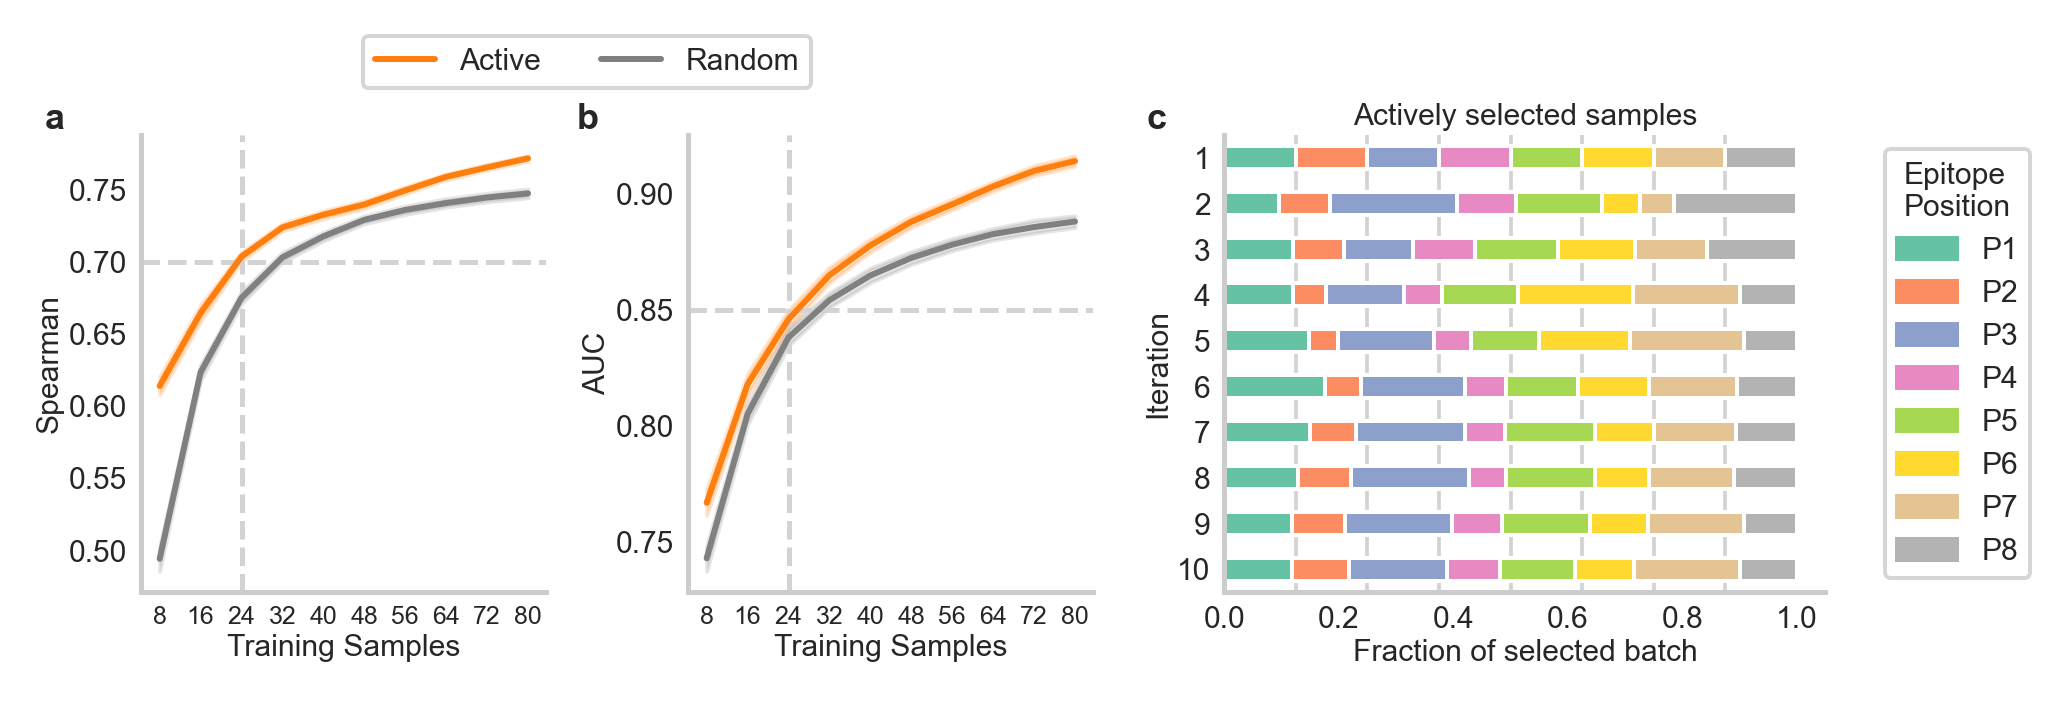

In [17]:
set_font_size(6)
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-4'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    wspace=0.15,
    width_ratios=[1.2, 1],
)

gridspecs['gs12'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-4'][0],
    nrows=1,
    ncols=2,
    width_ratios=[1, 1],
    wspace=0.35,
)

gridspecs['gs34'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-4'][1],
    nrows=1,
    ncols=2,
    width_ratios=[1, 0.2],
)

axes['ax_1'] = fig.add_subplot(gridspecs['gs12'][0])
axes['ax_2'] = fig.add_subplot(gridspecs['gs12'][1])
axes['ax_3'] = fig.add_subplot(gridspecs['gs34'][0])
axes['ax_4'] = fig.add_subplot(gridspecs['gs34'][1])

groups = [i//8 for i in range(80)]
xticks = [8+8*i for i in range(10)]

plot_performance(results_within_mice, 'Spearman', ['Active', 'Random'], ax=axes['ax_1'], xticks=xticks)
plot_performance(results_within_mice, 'auc', ['Active', 'Random'], ax=axes['ax_2'], xticks=xticks, 
                 legend=True)

plot_used_apls(apls_within_mice['Active'], groups=groups,ax=axes['ax_3'], xticks=xticks, 
               title='Actively selected samples')

axes['ax_4'].axis('off')
plot_legend(ax=axes['ax_4'])

fig.text(0.085, 0.89, 'a', size='large', weight='bold')
fig.text(0.305, 0.89, 'b', size='large', weight='bold')
fig.text(0.54, 0.89, 'c', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig4_active.pdf', dpi=DPI, bbox_inches='tight')

## Stats

In [18]:
for metric in ['auc', 'Spearman']:
    print(f'-{metric}')
    for i in range(10):
        df_act = res_mice.query(f'metric=="{metric}" & method=="Active" & iteration=={i}')
        df_rdm = res_mice.query(f'metric=="{metric}" & method=="Random" & iteration=={i}')
        mean_act = df_act['value'].mean()
        mean_rdm = df_rdm['value'].mean()
        t_test = stats.ttest_ind(df_act[~df_act['value'].isna()]['value'].values, 
                                 df_rdm[~df_rdm['value'].isna()]['value'].values)
        print(f'It {i}: Active={mean_act:.3f} - Random={mean_rdm:.3f} - Diff={mean_act-mean_rdm:.3f} - pval={t_test[1]}')

-auc
It 0: Active=0.767 - Random=0.743 - Diff=0.024 - pval=2.6522708331220135e-09
It 1: Active=0.818 - Random=0.805 - Diff=0.013 - pval=9.138913082379177e-05
It 2: Active=0.846 - Random=0.838 - Diff=0.008 - pval=0.00393334776363545
It 3: Active=0.865 - Random=0.854 - Diff=0.011 - pval=6.205605750723881e-06
It 4: Active=0.878 - Random=0.865 - Diff=0.013 - pval=7.557886345869137e-10
It 5: Active=0.888 - Random=0.872 - Diff=0.016 - pval=6.341356973942025e-16
It 6: Active=0.895 - Random=0.878 - Diff=0.017 - pval=1.745203019301887e-21
It 7: Active=0.903 - Random=0.882 - Diff=0.021 - pval=4.513344211322382e-32
It 8: Active=0.910 - Random=0.885 - Diff=0.024 - pval=4.356185274717516e-43
It 9: Active=0.914 - Random=0.888 - Diff=0.026 - pval=8.504814626508887e-49
-Spearman
It 0: Active=0.614 - Random=0.494 - Diff=0.120 - pval=6.925833359486026e-101
It 1: Active=0.664 - Random=0.623 - Diff=0.041 - pval=1.674619820930491e-24
It 2: Active=0.703 - Random=0.675 - Diff=0.029 - pval=3.1318366559442428e

In [19]:
df_apl = apls_within_mice['Active']
df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith('pos')]]
df_tmp = df_tmp.apply(lambda x: x.value_counts())
df_tmp = df_tmp.fillna(0)
df_tmp = df_tmp.transpose()

groups = [i//8 for i in range(80)]
df_tmp['groups'] = groups
df_tmp = df_tmp.groupby('groups').sum()
df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
df_apls_mice = df_tmp
df_apls_mice

,1,2,3,4,5,6,7,8
groups,,,,,,,,
0,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000
1,0.095250,0.089417,0.221333,0.102667,0.151500,0.065417,0.060167,0.214250
2,0.119750,0.088667,0.121667,0.108333,0.144167,0.134667,0.125083,0.157667
3,0.119833,0.057500,0.136917,0.066167,0.133083,0.200917,0.186250,0.099333
4,0.147583,0.051167,0.167583,0.065333,0.118667,0.158833,0.198417,0.092417
5,0.175583,0.062250,0.183167,0.070333,0.126917,0.123083,0.153750,0.104917
6,0.150167,0.079250,0.191750,0.069667,0.155917,0.104417,0.142917,0.105917
7,0.129083,0.091833,0.205667,0.065833,0.154917,0.093583,0.149333,0.109750
8,0.118500,0.092250,0.186333,0.088000,0.153333,0.102000,0.167417,0.092167


In [20]:
(df_apls_mice.sum() / 10)

1    0.129833
2    0.083683
3    0.171208
4    0.085283
5    0.139492
6    0.121075
7    0.149350
8    0.120075
dtype: float64

## AIRR talk

In [21]:
set_font_size(20)

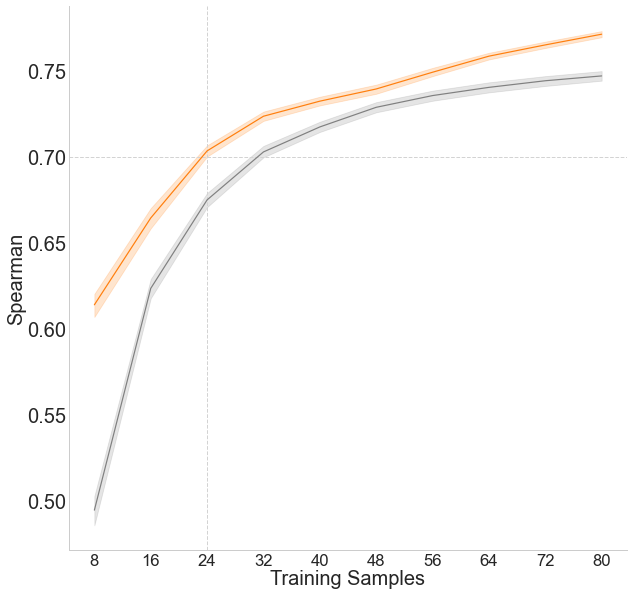

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plot_performance(results_within_mice, 'Spearman', ['Active', 'Random'], ax=ax, xticks=xticks)
plt.savefig('../figures/talk_active.png', bbox_inches='tight')
plt.show()

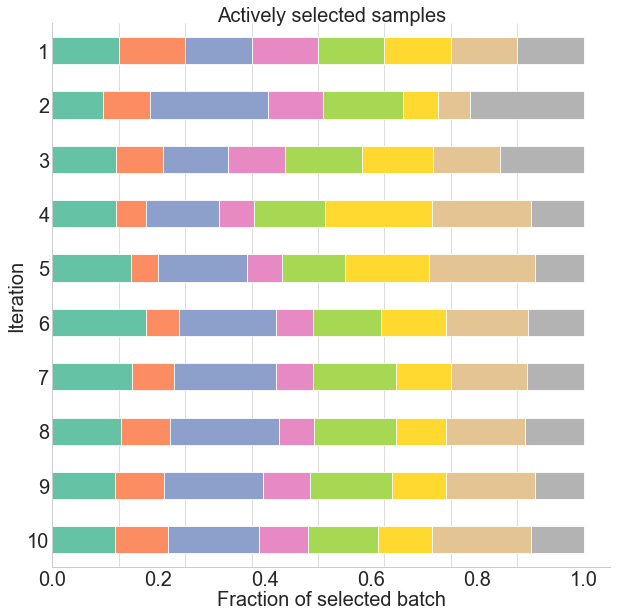

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
plot_used_apls(apls_within_mice['Active'], groups=groups,ax=ax, xticks=xticks, 
               title='Actively selected samples')
plt.show()